In [1]:
import joblib
import nltk
import pandas as pd
import re
import numpy as np
import time
import os

from datasets import load_dataset
from tqdm import tqdm
import json
import csv

from nltk.corpus import stopwords
from nltk.corpus import stopwords
from nltk.tokenize.treebank import TreebankWordDetokenizer
from nltk.tokenize import word_tokenize, sent_tokenize

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.base import BaseEstimator
from sklearn.base import TransformerMixin

import multiprocessing
from joblib import Parallel, delayed
import joblib
from collections import Counter
from scipy.sparse import csr_matrix

import torch
from torch.utils.data import DataLoader, Dataset, random_split
from sklearn.model_selection import train_test_split
import re
import codecs

/usr/lib/python3/dist-packages/requests/__init__.py:91: RequestsDependencyWarning: urllib3 (1.26.3) or chardet (3.0.4) doesn't match a supported version!
  RequestsDependencyWarning)


In [2]:
from scipy import stats

In [3]:
from pprint import pprint
import pandas as pd
import matplotlib.pyplot as plt

In [4]:
import numpy as np

In [5]:
def encode_word(word, vect_dictionnary):
    len_words=len(vect_dictionnary)
    vect_target= np.zeros(len_words, dtype=bool)
    vect_context= np.zeros(len_words, dtype=bool)
    if word in vect_dictionnary.keys():
        i=vect_dictionnary[word]
        vect_target[i]=True
    return torch.Tensor(np.hstack([vect_context,vect_target])).unsqueeze(0)
        

In [6]:
def encode_word_in_sentence(sentence,pos_target, vect_dictionnary):
    words= word_tokenize(sentence)
    target=words[pos_target:pos_target+1]
    context=words[:pos_target]+words[pos_target+1:]
    
    len_words=len(vect_dictionnary)
    vect_target= np.zeros(len_words, dtype=bool)
    vect_context= np.zeros(len_words, dtype=bool)
    
    for word in target:
        if word in vect_dictionnary.keys():
            i=vect_dictionnary[word]
            vect_target[i]=True
    for word in context:
        if word in vect_dictionnary.keys():
            i=vect_dictionnary[word]
            vect_context[i]=True
    return torch.Tensor(np.hstack([vect_context,vect_target])).unsqueeze(0)

In [7]:
from fruitFlyVectorizer import FruitFlyVectorizer

In [8]:
#nltk.download('punkt') #à executer une fois pour charger les données.
#nltk.download('stopwords') # à executer une fois pour charger les données.

english_stopwords=set(stopwords.words("english"))
detokenizer=TreebankWordDetokenizer()

def clean(x):
    x= x.lower()
    x= re.sub("[^ \w]"," ",x)
    x=re.sub("(\s\d+\s|^\d+\s)", " ", x)
    x=re.sub(" \d+", " <NUM> ", x) 
    x= re.sub("  "," ",x)
    words= word_tokenize(x)
    words = [w for w in words if not w in english_stopwords]
    clean_x = detokenizer.detokenize(words)
    return clean_x

class FruitFlyVectorizer(BaseEstimator, TransformerMixin):
    
    def __init__(self, max_words = 200,window=6 ):
        self.max_words = max_words
        self.window=window
        self.vect_dictionnary={}
        self.freq_dictionnary={}
        self.columns=[]
    
    def __getstate__(self):
        """Renvoie le dictionnaire d'attributs à sérialiser"""
        dict_attr = dict(self.__dict__)
        return dict_attr
    
    def __setstate__(self, dict_attr):
        """Méthode appelée lors de la désérialisation de l'objet"""
        self.__dict__ = dict_attr
        
    def get_vect_dictionnary(self):
        return self.vect_dictionnary()
    
    def get_freq_dictionnary(self):
        return self.freq_dictionnary()
    
    def parallel_fit(self, dataset, path,file_name):
        num_cores=1# multiprocessing.cpu_count() -1
        data_length= 1000#len(dataset)
        data_part_length= 125 #1000000
        dict_freq = {}
        plus_one = 1 if data_length%data_part_length != 0 else 0
        for i in range(int(data_length/data_part_length)+plus_one):
            # Fit par batch de taille data_part_length
            print("million == "+str(i+1))
            inf= i*data_part_length 
            sup = min(data_length, (i+1)*data_part_length)
            length = sup-inf+1
            step = int(length / num_cores) + 1
            processed_list = Parallel(n_jobs=num_cores)(delayed(self.fit)(dataset[inf+step*i:inf+min(step*(i+1),length)]) for i in range(0,num_cores))
            for sub_dic in processed_list:
                dict_freq = dict(Counter(sub_dic)+Counter(dict_freq))
            

        dict_freq_ordered={k: v for k, v in sorted(dict_freq.items(), key=lambda item: item[1], reverse=True)}
        self.freq_dictionnary= {k:v for i,(k,v) in enumerate(dict_freq_ordered.items()) if i<self.max_words}
        
        dict_freq_ordered={k:i for i,(k,v) in enumerate(dict_freq_ordered.items()) if i<self.max_words}
        self.vect_dictionnary=dict_freq_ordered
        
        self.max_words=len(dict_freq_ordered)
        self.columns= columns= [ 'context_' + i for i in self.vect_dictionnary.keys()]+["target_"+j for j in self.vect_dictionnary.keys()]
        
        f = open(path+"/dict_freq_ordered_"+ file_name + ".json", "w")
        dumped = json.dumps(dict_freq_ordered)
        f.write(dumped)
        f.close()

        f = open(path+"/freq_dictionnary_"+ file_name + ".json", "w")
        dumped = json.dumps(self.freq_dictionnary)
        f.write(dumped)
        f.close()
        
        return self
    
    def fit(self, dataset):
        """apprendre les paramètres necessaires à l'extraction de features"""
        
        dictionnary={}
        cpt=0
        for x in dataset["text"]:
            sents= sent_tokenize(x)
            for s in sents:
                clean_sent= clean(s)
                cpt+=1
                words=word_tokenize(clean_sent)
                for word in words:
                    if word in dictionnary.keys():
                        dictionnary[word]+=1
                    else:
                        dictionnary[word]=1
        return dictionnary
    
    def tokenize(self,words):
        vect=np.zeros(self.max_words, dtype=bool)
        for word in words:
            if word in self.vect_dictionnary.keys():
                i=self.vect_dictionnary[word]
                vect[i]=True
        return vect
    
    def parallel_transform(self, dataset, path, file_name):
        num_cores=multiprocessing.cpu_count() -1
        data_length= len(dataset)
        data_part_length= 10000
        plus_one = 1 if data_length%data_part_length != 0 else 0
        dict_freq = {}
        # Transform par batch de taille data_part_length
        for i in range(int(data_length/data_part_length)+plus_one):
            print("million 0.5 * == "+str(i))
            inf= i*data_part_length 
            sup = min(data_length, (i+1)*data_part_length)
            length = sup-inf+1
            step = int(length / num_cores) + 1
            print("Multiprocessing")
            processed_vects=Parallel(n_jobs=num_cores)(delayed(self.transform)(dataset[inf+step*i:inf+min(step*(i+1),length)], path, file_name) for i in range(0,num_cores))
            
            flatten_vect=[]
            for part_vect in processed_vects:
                flatten_vect+=part_vect
            with open(path + '/vectorized_data_'+file_name + "_"+str(i+104)+ '.csv', "w", newline="") as f:
                writer = csv.writer(f)
                writer.writerows(flatten_vect)
            processed_vects = None
            
        
            

    def transform(self, dataset,path, file_name):
        """extraire les features à partir des données en entrée """
        vect=[]
        cpt=0
        pid=os.getpid()
        num_file=0

        for value in tqdm(dataset["text"]):
            sents= sent_tokenize(value)
            for s in sents:
                sent= clean(s)
                words=word_tokenize(sent)
                rng=len(words)-self.window+1
                if rng>0:
                    start_time=time.time()
                    for i in range(rng):
                        subwords=words[i:i+self.window]
                        index= i + int(self.window/2)
                        target= subwords[index:index+1]
                        context= subwords[:index]+subwords[index+1:]
                        vect_target= self.tokenize(target)
                        vect_context= self.tokenize(context)
                        vect_combined= np.hstack([vect_context,vect_target])
                        cpt+=1
                        vect.append(csr_matrix(vect_combined))
    
        return vect
    
    def get_vectors_from_sentence(self, words, window,i):
        start_time=time.time()
        subwords=words[i:i+window]
        index= i + int(window/2)
        target= subwords[index:index+1]
        context= subwords[:index]+subwords[index+1:]
        vect_target=self.tokenize(target)
        vect_context= self.tokenize(context)
        vect_combined= np.hstack([vect_context,vect_target])
        return vect_combined

In [9]:
def model(word):
    return np.random.choice([0, 1], size=(20,), p=[3./4, 1./4])

In [10]:
W = torch.load("./weights_10_1718.pt")

In [11]:
W.shape

torch.Size([40000, 400])

In [12]:
from model import KCnetwork

In [13]:
vectorizer= joblib.load("./fruitFlyVectorizer_window=10.pkl")

In [14]:
dim_hidden = W.shape[1]
vocab_size = vectorizer.max_words
freq_words = torch.Tensor(list(vectorizer.freq_dictionnary.values()))
vect_dictionnary= vectorizer.vect_dictionnary

In [15]:
kcmodel = KCnetwork(dim_hidden, vocab_size, freq_words)


In [16]:
kcmodel.W = W
kcmodel = kcmodel.to("cpu")

In [17]:
sentence = "I love foot ball and food and cinema and dancing or traveling because it's good for our health "

In [18]:
vect=encode_word_in_sentence(sentence,5, vect_dictionnary).to("cuda")

In [19]:
kcmodel = kcmodel.to("cpu")

In [20]:
kcmodel.Hash(vect.to("cpu"),10).shape

torch.Size([1, 400])

## Dataset Functions 

In [21]:
## 1- Embedding Similarity Datasets

In [22]:
class DatasetsWordSimilarity:
    def __init__(self, vect_dictionnary, model):
        self.datasets= {"men": None , "rg45":None, "mturk":None, 'rw':None, "wordsim":None, "simlex":None}
        self.loaded=False
        self.vect_dictionnary=vect_dictionnary
        self.model=model
        
    def list_datasets(self):
        return self.datasets.keys()#"{men, rg45, mturk, rw, wordsim, simlex}"
        
    def get_dataset(self, dataset):
        if dataset in self.datasets.keys():
            return self.datasets[dataset]
        else : return None
    
    def load(self ):
        self.datasets["men"]=pd.read_csv('datasets/embedding_similarity/men/MEN_dataset_natural_form_full', sep=" ")
        self.datasets["men"]["score"]=self.datasets["men"]["score"].apply(lambda x : x/50)
        
        self.datasets["rg45"]=pd.read_csv('datasets/embedding_similarity/rg45/rg45.txt', sep=";")
        self.datasets["rg45"]["score"]=self.datasets["rg45"]["score"].apply(lambda x : x/4)
        
    
        self.datasets["rw"]=pd.read_csv('datasets/embedding_similarity/rw/rw.txt', sep="\t")
        self.datasets["rw"]["score"]=self.datasets["rw"]["score"].apply(lambda x : x/10)
        
        self.datasets["wordsim"]=pd.read_csv('datasets/embedding_similarity/wordsim/wordsim.txt', sep="\t")
        self.datasets["wordsim"]["score"]=self.datasets["wordsim"]["score"].apply(lambda x : x/10)
        
        self.datasets["mturk"]=pd.read_csv('datasets/embedding_similarity/mturk/mturk.txt', sep="\t")
        self.datasets["mturk"]["score"]=self.datasets["mturk"]["score"].apply(lambda x : (x-1)/4)
        
        self.datasets["simlex"] = pd.read_csv('datasets/embedding_similarity/SIMLEX/SimLex-999.txt', sep="\t")
        self.datasets["simlex"]["score"]=self.datasets["simlex"]["score"].apply(lambda x : x/10)
        
        self.loaded=True
        return True
    
    
    def calcul_similarity(self, dataset, k):
        if self.loaded:
            if dataset in self.datasets.keys():
                data= self.datasets[dataset].copy()
                data['emb1']= data['word1'].apply(lambda x : self.model.Hash(encode_word(x, self.vect_dictionnary), k))
                data["emb2"]=data['word2'].apply(lambda x :self.model.Hash(encode_word(x, self.vect_dictionnary), k))
                #data['score_emb']= data[["emb1", "emb2"]].apply(lambda x:  print(x))
                f = lambda x, y : np.equal(x, y).sum()/len(x)
                data['score_emb']= data[["emb1", "emb2"]].apply(lambda x : f(x["emb1"], x["emb2"]), axis=1)
                self.datasets[dataset]["score_emb"]= data["score_emb"]
                res=stats.spearmanr(self.datasets[dataset]["score"].values, self.datasets[dataset]["score_emb"].values)[0]
                return res*100
            else :
                return -1
        else:
            print("Veuillez d'abord charger les datasets svp !!")
            return -1
            

In [23]:
dataset= DatasetsWordSimilarity(vectorizer.vect_dictionnary , kcmodel)

In [24]:
dataset.list_datasets()

dict_keys(['men', 'rg45', 'mturk', 'rw', 'wordsim', 'simlex'])

In [25]:
dataset.load()

True

### Functions for Contextual Word embeddings

In [26]:
result = {}
for dataset_name in dataset.list_datasets():
    result[dataset_name] = dataset.calcul_similarity(dataset_name, 51)

/pytorch/aten/src/ATen/native/BinaryOps.cpp:81: UserWarning: Integer division of tensors using div or / is deprecated, and in a future release div will perform true division as in Python 3. Use true_divide or floor_divide (// in Python) instead.


In [27]:
# c'est pas très bon ! 
result

{'men': 2.155835604257246,
 'rg45': -9.460783118486896,
 'mturk': 4.264209580728077,
 'rw': 10.700939845941736,
 'wordsim': -12.628233409086825,
 'simlex': -8.593301726655648}

In [28]:
vectorizer.freq_dictionnary

{'said': 19131810,
 'one': 17578296,
 'would': 13657831,
 'new': 11966179,
 'also': 11758927,
 'like': 11752868,
 'people': 11464198,
 'time': 11133835,
 'first': 9315632,
 'two': 8535278,
 'year': 8371633,
 'could': 7762577,
 'get': 7716015,
 'even': 7363850,
 'us': 6856894,
 'years': 6776448,
 'many': 6547614,
 'make': 6405978,
 'may': 6141195,
 'way': 6055236,
 'last': 6004321,
 'well': 5982865,
 'back': 5960122,
 'world': 5821827,
 'see': 5777606,
 'state': 5620621,
 'much': 5603476,
 'know': 5155810,
 'game': 5119904,
 'work': 5094727,
 'use': 5063042,
 'made': 5061055,
 'think': 5028111,
 'right': 4894580,
 'still': 4889353,
 'going': 4876301,
 'good': 4745005,
 'government': 4623533,
 'day': 4618530,
 'take': 4546232,
 'want': 4462756,
 'says': 4446650,
 'go': 4396257,
 'three': 4380168,
 'since': 4249669,
 'team': 4183680,
 'around': 4146573,
 'say': 4071332,
 'long': 4064127,
 'need': 4061362,
 'really': 4038008,
 'trump': 4026793,
 'used': 4003415,
 'part': 3921133,
 'another

## Clustering

In [50]:
from sklearn.cluster import KMeans
from sklearn.cluster import AgglomerativeClustering
from scipy.cluster import hierarchy

In [51]:
class KmeansClustering():
    def __init__(self,model, vect_dictionnary):
        self.model = model
        self.words= vect_dictionnary.keys()
        self.vect_dictionnary= vect_dictionnary
        self.embeddings=None
        self.k=None
        
    def get_embeddings(self,k):
        self.k=k
        embeddings=[]
        for word in self.words:
            embeddings.append(list(self.model.Hash(encode_word(word, self.vect_dictionnary),k).squeeze(0)))
        self.embeddings= embeddings
        return True
    
    def fit(self, n_clusters):
        self.clustering_model = KMeans(n_clusters=n_clusters, random_state=0, verbose=1).fit(self.embeddings)
        
    def predict(self, words):
        emb_words=[]
        for word in words: 
            emb_words.append(list(self.model.Hash(encode_word(word, self.vect_dictionnary),self.k).squeeze(0)))
        return self.clustering_model.predict(emb_words)
        
    def get_words_of_cluster(self, cluster):
        return self.words[self.model.predict(self.embeddings)==cluster]
    

In [86]:
class AggClustering():
    def __init__(self,model, vect_dictionnary, n_clusters):
        self.model = model
        self.words= list(vect_dictionnary.keys())
        self.vect_dictionnary= vect_dictionnary
        self.n_clusters = n_clusters
        self.embeddings=None
        self.k=None
        
    def get_embeddings(self,k):
        self.k=k
        embeddings=[]
        for word in self.words:
            embeddings.append(list(self.model.Hash(encode_word(word, self.vect_dictionnary),k).squeeze(0)))
        self.embeddings= embeddings
        return True
    
    def fit(self):
        self.model = AgglomerativeClustering(n_clusters=self.n_clusters,affinity="cosine", linkage="average").fit(self.embeddings)
        
    
    def print_dendogram(self):
        fig, ax = plt.subplots(figsize=(20, 20))
        dend = hierarchy.dendrogram(
            hierarchy.linkage(self.embeddings, method="ward"),
            truncate_mode="lastp",
            metric='cosine',
            p=20,
            show_contracted=True,
        )
        fig.savefig("./datasets/sub_hierarchy.png", dpi=300)
        
    def get_words_of_cluster(self, cluster_id):
        words=np.array(self.words)
        return words[self.model.labels_==cluster_id]
    

In [87]:
cluster = AggClustering(kcmodel, vectorizer.vect_dictionnary, 50)
cluster.get_embeddings(50)

True

In [88]:
cluster.fit()

In [89]:
res={}
for i in range(cluster.k):
    res[i] = len(cluster.get_words_of_cluster(i))

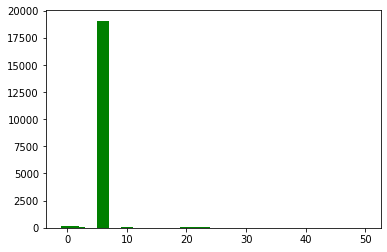

In [91]:
width = 2
plt.bar(res.keys(), res.values(), width, color='g')
plt.show()

In [93]:
cluster.get_words_of_cluster(6)

array(['said', 'one', 'would', ..., 'buggy', 'bd', 'counselling'],
      dtype='<U18')

## Contextual word embeddig

In [73]:
class KNearestNeighbors():
    def __init__(self,model, vect_dictionnary):
        self.model=model
        self.vect_dictionnary=vect_dictionnary
        self.words=self.vect_dictionnary.keys()
        self.embeddings=None
        self.k=0
        
    
    def get_embeddings(self,k):
        self.k=k
        embeddings=[]
        for word in self.words:
            embeddings.append(self.model.Hash(encode_word(word, self.vect_dictionnary),k).squeeze(0))
        self.embeddings= embeddings
        return True
    
    
    def get_neighbors(self,sentence, pos_target, num_neighbors):
        vect= encode_word_in_sentence(sentence, pos_target, self.vect_dictionnary)
        dict_scores= {}
        for embedding,word in zip(self.embeddings, self.words):
            vect_word=self.model.Hash(vect.to("cpu"),self.k).squeeze(0)
            #print(vect_word.shape)
            calcul_similarite = lambda x, y : torch.eq(x, y).int().sum()*1.0/x.shape[0]
            dict_scores[word]= calcul_similarite(vect_word, embedding).item()
        dict_scores= sorted(dict_scores.items(), key=lambda x: x[1], reverse=True)
        list_best_scores= dict_scores[:num_neighbors]
        dict_scores={k:v for (k,v) in list_best_scores}
        return dict_scores
    
        

# WordCloud

In [111]:
nn=KNearestNeighbors(kcmodel, vectorizer.vect_dictionnary)

In [112]:
nn.get_embeddings(50)


True

In [84]:
words=vectorizer.vect_dictionnary.keys()

In [128]:
'weapons' in words

True

In [199]:
freq_dist=nn.get_neighbors("soviet",0,20)

In [200]:
## Word cloud

In [201]:
from wordcloud import WordCloud
def plot_word_cloud(freq_dist):
    ''' Plot a word cloud visualisation to see most words used
    Args:
        freq_dist (array-like): Words distribution  get from nltk.FreqDist
    '''
    wordcloud = WordCloud(background_color='White').generate_from_frequencies(freq_dist)
    plt.figure(figsize=(8,6))
    plt.imshow(wordcloud,interpolation='bilinear')
    plt.axis('off')
    plt.show()

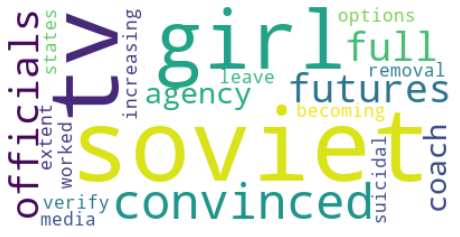

In [202]:
plot_word_cloud(freq_dist)

In [154]:
torch.load("tensor_freq_10.pt")

tensor([1.4895e-02, 1.4953e-02, 1.4862e-02,  ..., 5.2711e-06, 4.3092e-06,
        4.5068e-06])

## Document Classification

In [ ]:
## functions to load the datasets are in prepare_datasets.ipynb notebook.
## datasets are in ./datasets/document_classification/document_classification_datasets.zip

### 20newsgroup dataset

In [7]:
class newsgroupDATASET(Dataset):
    def __init__(self, news, labels):
        self.news = news
        self.labels = labels
    def __getitem__(self, index):
        """ r e t o u r n e un c o u p l e ( exemple , l a b e l ) c o r r e s p o n d a n t a l ’ i n d e x """
        x, y = self.news[index], self.labels[index]
        
        return x, y
        
    def __len__(self):
        """ r e n v o i e l a t a i l l e du j e u de donnees """
        return len(self.labels)

In [8]:
from sklearn.datasets import fetch_20newsgroups

newsgroup_train_X, newsgroup_train_y = fetch_20newsgroups(subset="train", download_if_missing=False, 
                                                          return_X_y=True, shuffle=True,
                                                          random_state=1, remove=('headers', 'footers', 'quotes'))
newsgroup_test_X, newsgroup_test_y = fetch_20newsgroups(subset="test", download_if_missing=False, 
                                                        return_X_y=True, shuffle=True,
                                                        random_state=1, remove=('headers', 'footers', 'quotes'))

In [9]:
# return : tuple of news, tensor of labels
train_loader = DataLoader(newsgroupDATASET(newsgroup_train_X, newsgroup_train_y), batch_size=32, shuffle=False)
test_loader = DataLoader(newsgroupDATASET(newsgroup_test_X, newsgroup_test_y), batch_size=32, shuffle=False)

In [10]:
for x, y in train_loader:
    print("Length news batch:", len(x))
    print("Targets:", y)
    break

Length news batch: 32
Targets: tensor([17,  0, 17, 11, 10, 15,  4, 17, 13, 12,  1,  6, 13, 15,  4, 11, 11, 10,
        12, 19, 12, 12, 16, 16, 10, 15,  6, 11, 10,  8, 11,  4])


### WOS-11967

In [11]:
class WOSDATASET(Dataset):
    def __init__(self, documents, labels):
        self.documents = documents
        self.labels = labels
    def __getitem__(self, index):
        """ r e t o u r n e un c o u p l e ( exemple , l a b e l ) c o r r e s p o n d a n t a l ’ i n d e x """
        x, y = self.documents[index], self.labels[index]
        
        return x, y
        
    def __len__(self):
        """ r e n v o i e l a t a i l l e du j e u de donnees """
        return len(self.labels)

In [12]:
def _generate_examples(input_file, label_file, label_level_1_file, label_level_2_file):
        """Yields examples."""
        with open(input_file, encoding="utf-8") as f:
            input_data = f.readlines()
        with open(label_file, encoding="utf-8") as f:
            label_data = f.readlines()
        with open(label_level_1_file, encoding="utf-8") as f:
            label_level_1_data = f.readlines()
        with open(label_level_2_file, encoding="utf-8") as f:
            label_level_2_data = f.readlines()
        for i in range(len(input_data)):
            yield i, {
                "input_data": input_data[i],
                "label": label_data[i],
                "label_level_1": label_level_1_data[i],
                "label_level_2": label_level_2_data[i],
            }
            
def _read_data(input_file, label_file, label_level_1_file, label_level_2_file):
    with open(input_file, encoding="utf-8") as f:
        input_data = f.readlines()
    with open(label_file, encoding="utf-8") as f:
        label_data = f.readlines()
        label_data = list(map(lambda s: int(s.strip()), label_data))
    with open(label_level_1_file, encoding="utf-8") as f:
        label_level_1_data = f.readlines()
    with open(label_level_2_file, encoding="utf-8") as f:
        label_level_2_data = f.readlines()
    return input_data, label_data, label_level_1_data, label_level_2_data

In [19]:
dir_path = "./datasets/document classification/datasets/WOS11967/"
input_file = dir_path + "X.txt"
label_file = dir_path + "Y.txt"
label_level_1_file = dir_path + "YL1.txt"
label_level_2_file = dir_path + "YL2.txt"

In [20]:
examples = _generate_examples(input_file, label_file, label_level_1_file, label_level_2_file)

In [21]:
for example in examples:
    print(example[1]["label"])
    break

10



In [22]:
input_data, label_data, label_level_1_data, label_level_2_data = _read_data(input_file, label_file, label_level_1_file, label_level_2_file)

In [25]:
input_data_train, input_data_test, label_data_train, label_data_test = train_test_split(input_data, 
                                                                                        label_data,
                                                                                        test_size=0.2,
                                                                                        stratify=label_data)

In [26]:
# return : tuple of documents, tensor of labels
train_loader = DataLoader(WOSDATASET(input_data_train, label_data_train), batch_size=32, shuffle=True)
test_loader = DataLoader(WOSDATASET(input_data_test, label_data_test), batch_size=32, shuffle=True)

In [27]:
for x, y in train_loader:
    print("Length documents batch:", len(x))
    print("Example : \n", x[0])
    print("Targets:", y)
    break

Length documents batch: 32
Example : 
 Background: Human papillomavirus (HPV) infection is linked to cervical cancer. With the technological development of molecular biology and epidemiology, detection and treatment of HPV has become an important mean to prevent cervical cancer. Methods: A simple, rapid, and sensitive colorimetric loop-mediated isothermal amplification (LAMP) method was established herein to detect 23 HPV genotypes. The sequences of the primers for the LAMP reaction were located in the L1 gene of the HPV genome. As it is a fluorescent dye, calcein was added before the reaction. The reaction was run under isothermal conditions at 65 degrees C for 40 minutes. A positive reaction was indicated by a color change from yellow to fluorescent green. The fluorescence curve diagram represents the monitoring of real time quantitative instrument. 450 cervical swab samples from patients with single infections of 23 different HPV genotypes were examined to evaluate the specificity. 

### TREC-6 dataset

In [28]:
class TREC6DATASET(Dataset):
    def __init__(self, questions, labels):
        self.questions = questions
        self.labels = labels
    def __getitem__(self, index):
        """ r e t o u r n e un c o u p l e ( exemple , l a b e l ) c o r r e s p o n d a n t a l ’ i n d e x """
        x, y = self.questions[index], self.labels[index]
        
        return x, y
        
    def __len__(self):
        """ r e n v o i e l a t a i l l e du j e u de donnees """
        return len(self.labels)

In [33]:
train_file = "./datasets/document classification/datasets/TREC-6/train.txt"
test_file = "./datasets/document classification/datasets/TREC-6/test.txt"

In [34]:
def convert_data(data_name):
    features = []
    lbl = []
    with codecs.open(data_name, 'r', encoding="latin-1") as f:
        for line in f:
            words = clean_str(line.strip())[2:]
            y = int(line[0])
            features.append(words)
            lbl.append(y)
    return features, lbl



def clean_str(string):
    
    string = re.sub(r"[^A-Za-z0-9(),!?\'\`]", " ", string)
    string = re.sub(r"\'s", " \'s", string)
    string = re.sub(r"\'ve", " \'ve", string)
    string = re.sub(r"n\'t", " n\'t", string)
    string = re.sub(r"\'re", " \'re", string)
    string = re.sub(r"\'d", " \'d", string)
    string = re.sub(r"\'ll", " \'ll", string)
    string = re.sub(r",", " , ", string)
    string = re.sub(r"!", " ! ", string)
    string = re.sub(r"\(", " ( ", string)
    string = re.sub(r"\)", " ) ", string)
    string = re.sub(r"\?", " ? ", string)
    string = re.sub(r"\s{2,}", " ", string)
    return string.strip()


In [35]:
# Dataset name
train_input, train_output = convert_data(train_file)
test_input, test_output = convert_data(test_file)

In [36]:
# return : tuple of documents, tensor of labels
train_loader = DataLoader(WOSDATASET(train_input, train_output), batch_size=32, shuffle=True)
test_loader = DataLoader(WOSDATASET(test_input, train_output), batch_size=32, shuffle=True)

In [37]:
for x, y in train_loader:
    print("Length questions batch:", len(x))
    print("Example : \n", x[0])
    print("Targets:", y)
    break

Length questions batch: 32
Example : 
 What is `` cat scratch fever '' ?
Targets: tensor([0, 1, 4, 5, 0, 5, 0, 0, 3, 3, 1, 4, 3, 3, 1, 1, 4, 5, 3, 0, 0, 5, 0, 1,
        0, 0, 1, 3, 1, 1, 1, 4])


### SST dataset

In [39]:
class SSTDATASET(Dataset):
    def __init__(self, reviews, labels):
        self.reviews = reviews
        self.labels = labels
    def __getitem__(self, index):
        """ r e t o u r n e un c o u p l e ( exemple , l a b e l ) c o r r e s p o n d a n t a l ’ i n d e x """
        x, y = self.reviews[index], self.labels[index]
        
        return x, y
        
    def __len__(self):
        """ r e n v o i e l a t a i l l e du j e u de donnees """
        return len(self.labels)

In [40]:
train_file = "./datasets/document classification/datasets/SST/train.txt"
test_file = "./datasets/document classification/datasets/SST/test.txt"

In [41]:
# Dataset name
train_input, train_output = convert_data(train_file)
test_input, test_output = convert_data(test_file)

In [42]:
# return : tuple of documents, tensor of labels
train_loader = DataLoader(SSTDATASET(train_input, train_output), batch_size=32, shuffle=False)
test_loader = DataLoader(SSTDATASET(test_input, train_output), batch_size=32, shuffle=False)

In [43]:
for x, y in train_loader:
    print("Length reviews batch:", len(x))
    print("Example : \n", x[0])
    print("Targets:", y)
    break

Length reviews batch: 32
Example : 
 a stirring , funny and finally transporting re imagining of beauty and the beast and 1930s horror films
Targets: tensor([1, 0, 0, 1, 1, 1, 0, 1, 0, 0, 1, 0, 0, 1, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0,
        0, 1, 1, 0, 1, 0, 0, 1])


### TextCNN de Yoon Kim : https://arxiv.org/abs/1408.5882

In [264]:
BATCH_SIZE = 64

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [265]:
class CNN1d(torch.nn.Module):
    def __init__(self, vocab_size, embedding_dim, n_filters, filter_sizes, output_dim, 
                 dropout, pad_idx):
        
        super().__init__()
        
        self.embedding = None
        
        self.conv_0 = torch.nn.Conv1d(in_channels = embedding_dim, 
                                out_channels = n_filters, 
                                kernel_size = filter_sizes[0])
        
        self.conv_1 = torch.nn.Conv1d(in_channels = embedding_dim, 
                                out_channels = n_filters, 
                                kernel_size = filter_sizes[1])
        
        self.conv_2 = torch.nn.Conv1d(in_channels = embedding_dim, 
                                out_channels = n_filters, 
                                kernel_size = filter_sizes[2])
        
        
        self.fc = torch.nn.Linear(len(filter_sizes) * n_filters, output_dim)
        
        self.dropout = torch.nn.Dropout(dropout)
        
    def set_embedding(self, Embedding):
        
        self.embedding = Embedding
        return True
        
    def forward(self, text):
        
        #text = [batch size, len]
        embedded = self.embedding(text)
                
        #embedded = [batch size, len, emb dim]
        embedded = embedded.permute(0, 2, 1)
        
        #conved_n = [batch size, n_filters, len - filter_sizes[n] + 1]
        conved_0 = F.relu(self.conv_0(embedded))
        conved_1 = F.relu(self.conv_1(embedded))
        conved_2 = F.relu(self.conv_2(embedded))
        
        #pooled_n = [batch size, n_filters]    
        pooled_0 = F.max_pool1d(conved_0, conved_0.shape[2]).squeeze(2)
        pooled_1 = F.max_pool1d(conved_1, conved_1.shape[2]).squeeze(2)
        pooled_2 = F.max_pool1d(conved_2, conved_2.shape[2]).squeeze(2)
        
        #cat = [batch size, n_filters * len(filter_sizes)]
        cat = self.dropout(torch.cat((pooled_0, pooled_1, pooled_2), dim = 1))
            
        return self.fc(cat)

In [268]:
def train(model, train_loader, optimizer, criterion):
    
    epoch_loss = 0
    epoch_acc = 0
    
    model.train()
    
    for x_train, y_train in train_loader:
        
        optimizer.zero_grad()
        
        predictions = model(x_train).squeeze(1)
        
        loss = criterion(predictions, y_train)
        
        acc = binary_accuracy(predictions, y_train)
        
        loss.backward()
        
        optimizer.step()
        
        epoch_loss += loss.item()
        epoch_acc += acc.item()
        
    return epoch_loss / len(train_loader), epoch_acc / len(train_loader)

In [269]:
def evaluate(model, test_loader, criterion):
    
    epoch_loss = 0
    epoch_acc = 0
    
    model.eval()
    
    with torch.no_grad():
    
        for x_test, y_test in test_loader:

            predictions = model(x_test).squeeze(1)
            
            loss = criterion(predictions, y_test)
            
            acc = binary_accuracy(predictions, y_test)

            epoch_loss += loss.item()
            epoch_acc += acc.item()
        
    return epoch_loss / len(test_loader), epoch_acc / len(test_loader)

In [266]:
input_dim = None # vocab_size 
embedding_dim = 100
n_filters = 100
filter_sizes = [3,4,5]
output_dim = 1
dropout = 0.5
PAD_IDX = None # pad_idx

model = CNN1d(input_dim, embedding_dim, n_filters, filter_sizes, output_dim, dropout, PAD_IDX)

In [267]:
optimizer = torch.optim.Adam(model.parameters())

criterion = torch.nn.BCEWithLogitsLoss()

model = model.to(device)
criterion = criterion.to(device)

In [ ]:
train_loader = None
test_loader = None

iterations = 10

best_valid_loss = float('inf')

for epoch in range(iterations):

    train_loss, train_acc = train(model, train_loader, optimizer, criterion)
    test_loss, test_acc = evaluate(model, test_loader, criterion)
    
    
    print("Epoch: ", (epoch+1)) 
    print("Train Loss", train_loss, "Train accuracy", train_acc*100)
    print("Test Loss", test_loss, "Test accuracy", test_acc*100)